In [11]:
print("Working")


Working


In [1]:
from torch.utils.data import DataLoader

import sys
import time
import torch.nn as nn
import numpy as np
import  pandas as pd
import  torch
from torchvision import models, transforms,datasets
from PIL import Image
import os
import matplotlib.pyplot as plt
from collections import Counter
from src.model import SkinCancerModel, MelanomaClassifier
from src.dataset import MelanomaDataset,data_preprocessing,Normalize,MelanomaImageDataset,MelanomaHam1000Dataset
from torch.utils.data import DataLoader
from src.model_training import train_model,test_model,save_weights,save_epochs_to_csv
from torch.optim import Adam
import time
from sklearn.model_selection import train_test_split


In [13]:
torch.cuda.empty_cache()

In [14]:

train_history=pd.read_csv("train_data.csv",index_col=False)

In [15]:
train_history

,Unnamed: 0,Train Loss,no train rows,Test Loss,No test rows,Time taken (M),Notes,Date,Time
0,0,0.333126,7511,0.32250981595807565,2504,10.78542274236679:00,"data standardization + classifier (1280,256,1)",18/05/2022,03:42 AM
1,0,0.310118,7511,0.2955880169133721,2504,8.317672594388325:00,"data standardization + classifier (1280,256,1)",18/05/2022,03:52 AM
2,0,0.307698,7511,0.3134859832484995,2504,8.297154140472411:00,"data standardization + classifier (1280,256,1)",18/05/2022,04:01 AM
3,0,0.295923,7511,0.2874756509623729,2504,8.17770220041275:00,"data standardization + classifier (1280,256,1)",18/05/2022,04:09 AM
4,0,0.284783,7511,0.2851723327947957,2504,8.252407503128051:00,"data standardization + classifier (1280,256,1)",18/05/2022,04:17 AM
...,...,...,...,...,...,...,...,...,...
237,0,0.074609,7320,"tensor(0.2545, device='cuda:0')",2441,9.25445496638616:00,NaN,25/05/2022,02:55 AM
238,0,0.071283,7320,"tensor(0.2503, device='cuda:0')",2441,9.280335708459218:00,NaN,25/05/2022,03:05 AM
239,0,0.059004,7320,"tensor(0.2414, device='cuda:0')",2441,9.477825403213501:00,NaN,25/05/2022,03:14 AM
240,0,0.067086,7320,"tensor(0.3267, device='cuda:0')",2441,9.270533955097198:00,NaN,25/05/2022,03:23 AM


In [16]:
combined_path="../dataset/preprocessed/mel_combined_dataset"

In [2]:
img_dataset_path="../dataset/preprocessed/ham1000"
img_train_csv_path="..\\dataset\\preprocessed\\ham1000_train.csv"
img_test_csv_path="..\\dataset\\preprocessed\\ham1000_test.csv"
weights_path="..\\model_weights\\weights.pt"

train_transform=transforms.Compose([transforms.ToTensor(),transforms.RandomHorizontalFlip(),transforms.RandomRotation(10),Normalize()])
test_transform=transforms.Compose([transforms.ToTensor(),Normalize()])

combined_path="../dataset/preprocessed/mel_combined_dataset"
train_feature_dataset=MelanomaImageDataset(img_train_csv_path,img_dataset_path,train_transform)
test_feature_dataset=MelanomaImageDataset(img_test_csv_path,img_dataset_path,test_transform)

combined_dataset=MelanomaDataset(combined_path,{"melanoma":1,"bengin":0},train_transform)

In [18]:
train_feature_loader=DataLoader(train_feature_dataset,shuffle=True,batch_size=4)
test_feature_loader=DataLoader(test_feature_dataset,shuffle=True,batch_size=1)

# Melanoma Features extraction Model Training


In [19]:
combined_loader=DataLoader(combined_dataset,shuffle=True,batch_size=4)
img,l=next(iter(combined_dataset))
l

tensor([1.])

In [ ]:
train_melanoma,test_melanoma=train_test_split(combined_dataset)

In [ ]:
img,l=next(iter(train_feature_dataset))
img
l

tensor([0.])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


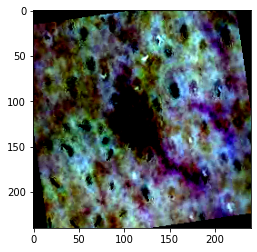

In [ ]:

plt.imshow(img.numpy().transpose([1,2,0]))
plt.show()

In [21]:
from src.model import SkinCancerModel

In [22]:

model=SkinCancerModel(True,"efficientnet_b1")


In [23]:
model

SkinCancerModel(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation

In [24]:
len(model.features)

9

In [25]:
model.classifier

Sequential(
  (0): Dropout(p=0.25, inplace=False)
  (1): Linear(in_features=1280, out_features=256, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

In [26]:
for i in range(4):
        for par in model.features[i].parameters():
          par.requires_grad=False

In [ ]:
model.save_weights("weights.pt")

In [ ]:
model.load_local_weights("weights.pt")

In [ ]:
train_model()

In [ ]:
  model_training.save_epochs_to_csv("",train_loss_avg,len(train_loader.dataset),test_loss,len(test_loader.dataset),epoch_time,train_notes)


In [ ]:
model.cuda()

In [ ]:
model.load_local_weights("weights.pt")

In [ ]:
model.cuda()

In [ ]:
count=0
loss_test=0.0
melanoma_score_sum=0.0
cnt_melanoma=0
cnt_non_melanoma=0
non_melanona_score_sum=0.0
model.eval()
with torch.no_grad():
  for img ,label in test_loader:
          img=img.cuda()
          label=label.cuda()
          result=model(img)

          if label.item()==1:
            melanoma_score_sum+=result.cpu().item()
            cnt_melanoma+=1
          else:
            non_melanona_score_sum+=result.cpu().item()
            cnt_non_melanoma+=1

          if result>0.28:
                result=1
          else:
                  result=0

          if result==label:
                  count+=1
model.train()

In [ ]:
cnt_non_melanoma

In [ ]:
accuracy=(count/len(test_loader))*100
print(accuracy)
print(melanoma_score_sum/cnt_melanoma)
print(non_melanona_score_sum/cnt_non_melanoma)

In [ ]:
len(train_loader)

# Melanoma Classifier Model Train

In [4]:
weights_path="../model_weights/melanomaClassifier"

In [5]:
train_data=MelanomaHam1000Dataset(img_train_csv_path,img_dataset_path,train_transform)
test_data=MelanomaHam1000Dataset(img_test_csv_path,img_dataset_path,test_transform)

In [6]:
train_loader=DataLoader(train_data,shuffle=True,batch_size=4)
test_loader=DataLoader(test_data,shuffle=True,batch_size=1)

In [7]:
classifier_model=MelanomaClassifier(17)
# classifier_model.cuda()


In [12]:
itr=iter(train_loader)


In [13]:
img,data,label=next(itr)

print(classifier_model(img,data))
print(label)

tensor([[0.7188],
        [0.8351],
        [0.8816],
        [0.8935]], grad_fn=<SigmoidBackward0>)
tensor([[0.],
        [0.],
        [0.],
        [0.]])


In [9]:
for i in range (4):
    for par in classifier_model.features.features[i].parameters():
      par.requires_grad=False

In [11]:
classifier_model.cuda()

MelanomaClassifier(
  (features): SkinCancerModel(
    (features): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): ConvNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (

In [12]:
train_model(classifier_model,1000,0.001,train_loader,test_loader,"classifier",cuda=True,weight_saving_path=weights_path,epoch_data_saving_path="",notes="")

 epoch 1 [==========] time remaining = 0.0 Avg train_loss=0.1801485063466793428962
new train loss =0.18014850634667934 new test loss= 0.19883665442466736
 over fitting
 epoch 1 train_loss =0.18014850634667934 test_loss=0.19883665442466736
 epoch 2 [==========] time remaining = 0.0 Avg train_loss=0.16256188178612832906047
 over fitting
 epoch 2 train_loss =0.16256188178612832 test_loss=0.2085896134376526
 epoch 3 [==========] time remaining = 0.0 Avg train_loss=0.15074262106899372357753
 over fitting
 epoch 3 train_loss =0.15074262106899372 test_loss=0.30394446849823
 epoch 4 [==========] time remaining = 0.0 Avg train_loss=0.143390871471963861344662
 over fitting
 epoch 4 train_loss =0.14339087147196386 test_loss=0.2174278050661087
 epoch 5 [==========] time remaining = 0.0 Avg train_loss=0.14074245889294829464254
 over fitting
 epoch 5 train_loss =0.14074245889294829 test_loss=0.2230292409658432
 epoch 6 [==========] time remaining = 0.0 Avg train_loss=0.1279638804957822508146
 over f

KeyboardInterrupt: 

In [13]:
classifier_model.load_local_weights("../model_weights/melanomaClassifier/05_24 19_57 Train_(0.111155) Test_(tensor(0).pt")

RuntimeError: Error(s) in loading state_dict for MelanomaClassifier:
	Missing key(s) in state_dict: "classifier.3.weight", "classifier.3.bias". 
	Unexpected key(s) in state_dict: "classifier.2.weight", "classifier.2.bias". 

In [26]:
count=0
loss_test=0.0
melanoma_score_sum=0.0
cnt_melanoma=0
cnt_non_melanoma=0
non_melanona_score_sum=0.0
classifier_model.eval()
with torch.no_grad():
  for img,data ,label in test_loader:
          img=img.cuda()
          data=data.cuda()
          label=label.cuda()
          result=classifier_model(img,data)

          if label.item()==1:
            melanoma_score_sum+=result.cpu().item()
            cnt_melanoma+=1
          else:
            non_melanona_score_sum+=result.cpu().item()
            cnt_non_melanoma+=1

          if result>0.32:
                result=1
          else:
                  result=0

          if result==label:
                  count+=1

In [27]:
accuracy=(count/len(test_loader))*100
print(accuracy)
print(melanoma_score_sum/cnt_melanoma)
print(non_melanona_score_sum/cnt_non_melanoma)

94.01884473576403
0.6215266735537971
0.04582214809162272


In [29]:
results_path=""
error = 0
data_cnt = len(test_loader.dataset)
cnt = 0.0
# row --> predicted Class  , cols --> true Class
threshold=0.32
confusion_matrix = [[0, 0], [0, 0]]
false_positive_rows = []
false_negative_rows = []
total_dist_same_persons = 0.0
total_dist_diff_persons = 0.0
avg_dist_same_persons = 0.0
avg_dist_diff_persons = 0.0
# 1--> two faces are for same person 0--> two faces are for different persons
time_sum = 0.0
with torch.no_grad():
  for img,data ,label in test_loader:
          img=img.cuda()
          data=data.cuda()
          label=label.cuda()
          result=classifier_model(img,data)

          if label.item()==1:
            melanoma_score_sum+=result.cpu().item()
            cnt_melanoma+=1
          else:
            non_melanona_score_sum+=result.cpu().item()
            cnt_non_melanoma+=1

          if result>0.32:
                result=1
          else:
                  result=0

          if result==label:
                  count+=1

    cnt += 1.0
    finished = int((cnt * 10) / data_cnt)

    remaining = 10 - finished
    te = time.time()
    time_sum += (te - ts)
    avg_time = time_sum / cnt
    time_remaing = avg_time * (data_cnt - cnt)
    accuracy = ((cnt - error) * 1.0 / cnt) * 100.0
    sys.stdout.write("\r Testing  [" + str(
        "=" * finished + str("." * remaining) + "] time remaining = " + str(
            time_remaing / 60.0)[:8]) + " Accuracy =" + str(round(accuracy, 3)))

avg_dist_same_persons /= total_dist_same_persons
avg_dist_diff_persons /= total_dist_diff_persons

accuracy = ((cnt - error) * 1.0 / cnt) * 100.0
print("Accuracy now equal --> {:.4f}%".format(accuracy))

confusion_table = pd.DataFrame(confusion_matrix, index=['Predicted True', 'Predicted False'],
                               columns=['Actual True', 'Actual False'])
precision = (confusion_matrix[0][0]) / (confusion_matrix[0][0] + confusion_matrix[0][1] + 1)
recall = (confusion_matrix[0][0]) / (confusion_matrix[0][0] + confusion_matrix[1][0] + 1)
beta = 0.5
beta_squared = beta ** 2
fbeta_score = ((1 + beta_squared) * (precision * recall)) / ((beta_squared * precision) + recall + 1)
error_matrix = [['processed rows', cnt],
                ['Model accuracy on Proceed Faces %', round(accuracy, 3)],
                ['False Positive', confusion_matrix[0][1]],
                ['False Negative', confusion_matrix[1][0]],
                ['precision', precision],
                ['recall', recall],
                ['fbeta-score', fbeta_score],
                ['avg same person distance', avg_dist_same_persons],
                ['avg diff person distance', avg_dist_diff_persons],
                ['Model tolerance', threshold]
                ]
model_name = "efficentnet"

error_table = pd.DataFrame(error_matrix, columns=['Mertic', 'Value'])

if results_path is not None:
    file_name = f"{model_name}__err.csv"
    full_path = os.path.join(results_path, file_name)
    error_table.to_csv(full_path)

    file_name = f"{model_name}_conv.csv"
    full_path = os.path.join(results_path, file_name)
    confusion_table.to_csv(full_path)

AttributeError: 'MelanomaHam1000Dataset' object has no attribute 'iterrows'

In [ ]:
confusion_table

In [ ]:
error_table